In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import random
import hypertools as hyp
import tensorflow as tf
%matplotlib inline
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

/Users/junyang/anaconda2/envs/p3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
def to_seconds(time, period):
    return int(time.split(':')[0])*60 + int(time.split(':')[1]) + 20*60*(period-1)

def have_missing_value(row):
    for item in row:
        if item == '':
            return True
    return False

def relative_court_position(x,y):
    if x > max_x / 2:
        x = max_x - x
        y = max_y - y
    return x,y

def datetime(date):
    day,month,year = date.split()[0].split('-')
    return '20'+year+'-'+month_dict[month]+'-'+day

# Loading Data

In [3]:
# a dict stores {key: game, value: [shot1, shot2,...,]}
# per game shotlogs, not per person
duke_shotlogs = defaultdict(list)
x_max = 0
y_max = 0
with open('duke_shotlog.csv','r') as f:
    csv_reader = csv.reader(f, delimiter=';')
    line_cnt = 0
    for row in csv_reader:
        if have_missing_value(row):
            continue
        if line_cnt == 0: ## skip the first attribute-line
            pass
        else:
            game_id = 'duke-'+row[10]+'-'+row[11]+'-'+row[12] #year-month-date
            shot_pos_time = (to_seconds(row[14], int(row[3])), int(row[7]), int(row[8]))
            if int(row[7]) > x_max:
                x_max = int(row[7])
            if int(row[8]) > y_max:
                y_max = int(row[8])
            duke_shotlogs[game_id].append(shot_pos_time)
        line_cnt += 1
print('{} shot log records in total'.format(line_cnt))
for game in duke_shotlogs.keys():
    duke_shotlogs[game] = sorted(duke_shotlogs[game], key = lambda x: x[0])

new_duke_shotlogs = defaultdict(list)
print(x_max,y_max)
for idx,game in enumerate(duke_shotlogs.keys()):
    if len(duke_shotlogs[game]) < 100:
        continue
    else:
        for item in duke_shotlogs[game]:
            if item[1] > x_max / 2:
                x = x_max - item[1]
                y = y_max - item[2]
            else:
                x = item[1]
                y = item[2]
            new_duke_shotlogs[game].append([item[0], x, y])



988 shot log records in total
91 49


# discretize the court

128
9


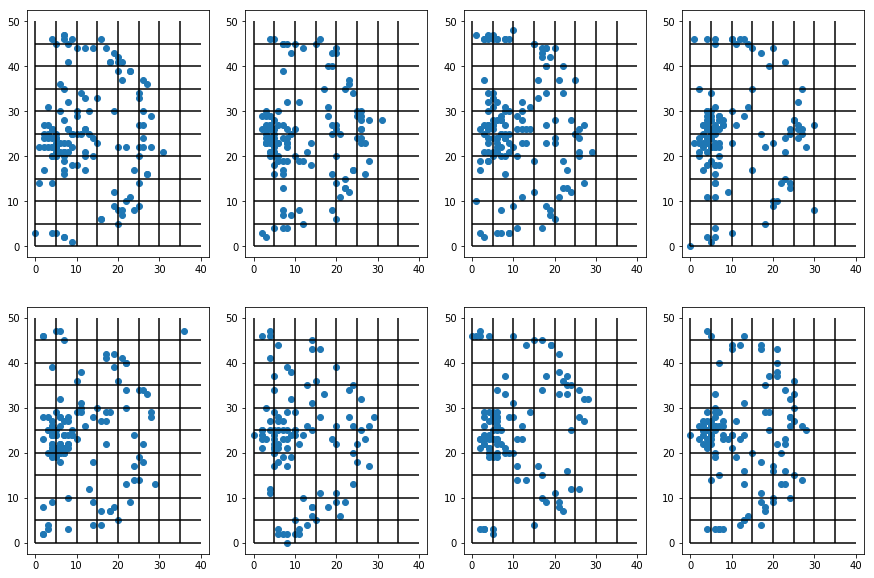

In [74]:
print(len(duke_shotlogs['duke-2016-3-9']))
print(len(duke_shotlogs))
plt.figure(figsize=(15,10))
for idx,game in enumerate(new_duke_shotlogs.keys()):
    plt.subplot(2,4,idx+1)
    x= []
    y= []
    for item in new_duke_shotlogs[game]:
        x.append(item[1])
        y.append(item[2])
    plt.scatter(x,y)
    for i in range(0,50,5):
        plt.hlines(i,0,40)
    for i in range(0,40,5):
        plt.vlines(i, 0, 50)

In [75]:
def gridify(x,y, grid_x=5, grid_y=5):
    x_idx = x // grid_x
    y_idx = y // grid_y
    return x_idx  + y_idx * (40 // grid_y)

In [77]:
print(gridify(30,4))

6


In [190]:
discrete_shotlogs = [] #should have shape (8,100,8*10)
for game in new_duke_shotlogs:
    game_sequence = []
    for shot in new_duke_shotlogs[game][:sequence_length]:
        idx = gridify(shot[1],shot[2])
        onehot = np.zeros((8*10,))
        onehot[idx] = 1
        #print(idx, onehot[idx])
        game_sequence.append(onehot)
    game_sequence = np.array(game_sequence).reshape((sequence_length, 8*10))
    discrete_shotlogs.append(game_sequence)
discrete_shotlogs = np.array(discrete_shotlogs).reshape((8, sequence_length, 8*10))
print(discrete_shotlogs.shape)

(8, 100, 80)


In [191]:
target_shotlogs = [] #should have shape (8,100,8*10)
for game in new_duke_shotlogs:
    game_sequence = []
    for shot in new_duke_shotlogs[game][1:sequence_length+1]:
        idx = gridify(shot[1],shot[2])
        onehot = np.zeros((8*10,))
        onehot[idx] = 1
        #print(idx, onehot[idx])
        game_sequence.append(onehot)
    game_sequence = np.array(game_sequence).reshape((sequence_length, 8*10))
    target_shotlogs.append(game_sequence)
target_shotlogs = np.array(target_shotlogs).reshape((8, sequence_length, 8*10))
target_shotlogs = target_shotlogs.transpose([1,0,2])
print(target_shotlogs.shape)

(100, 8, 80)


In [192]:
print(np.array_equal(discrete_shotlogs[0][1],target_shotlogs[0][0]))
print(np.array_equal(discrete_shotlogs[0][2],target_shotlogs[1][0]))
print(np.array_equal(discrete_shotlogs[0][3],target_shotlogs[2][0]))
print(np.array_equal(discrete_shotlogs[0][3],target_shotlogs[3][0]))

True
True
True
False


In [193]:
def recover_onehot(onehots):
    shots = []
    for item in onehots:
        idx = np.argmax(item)
        x = idx % 8
        y = idx // 8
        x = np.random.uniform(x*5, (x+1)*5)
        y = np.random.uniform(y*5, (y+1)*5)
        shots.append([x,y])
    return shots

(0, 50)

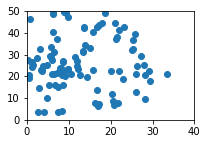

In [194]:
plt.figure(figsize=(3,2))
x=[]
y=[]
shots = recover_onehot(discrete_shotlogs[0])
for shot in shots:
    x.append(shot[0])
    y.append(shot[1])
plt.scatter(x,y)
plt.xlim(0,40)
plt.ylim(0,50)

# Model training

In [195]:
# hyperparameters
# num_layers = 2 # num of LSTM layers
hidden_units = 128 #Hidden size of the LSTM
# max_grad = 1 #Clip the gradients during training
sequence_length = 100
learning_rate = .0005
batch_size = 8 # we only have 8 games
num_features = 8*10 # x,y coordinates

In [196]:
reshapor = Reshape((1,num_features))
LSTM_cell = LSTM(hidden_units, return_state=True)
output_layer = Dense(num_features, activation='softmax')

In [197]:
def model(sequence_length, hidden_units, num_features):
    X = Input(shape=(sequence_length, num_features))
    
    a0 = Input(shape= (hidden_units,))
    c0 = Input(shape= (hidden_units,))
    
    a = a0
    c = c0
    
    outputs = []
    for t in range(sequence_length):
        x = Lambda(lambda x: X[:,t,:])(X)
        x = reshapor(x)
        a,_,c = LSTM_cell(x, initial_state=[a,c])
        out = output_layer(a)
        
        outputs.append(out)
    
    model = Model(inputs=[X,a0,c0], outputs=outputs)
    
    return model

In [198]:
shots_model = model(sequence_length, hidden_units, num_features)
adam_optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
shots_model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [199]:
a0 = np.zeros((8, hidden_units))
c0 = np.zeros((8, hidden_units))
shots_model.fit([discrete_shotlogs, a0, c0], list(target_shotlogs), epochs=5000, verbose=0)

In [174]:
def generation_model(LSTM_cell, output_layer, num_features, hidden_units, sequence_length):
    x0 = Input(shape=(1, num_features))
    
    a0 = Input(shape=(hidden_units,))
    c0 = Input(shape=(hidden_units,))
    
    a = a0
    c = c0
    x = x0
    
    outputs = []
    
    for t in range(sequence_length):
        a,_,c = LSTM_cell(x, initial_state=[a,c])
        
        out = output_layer(a)
        
        outputs.append(out)
        
        # x = Lambda(K.one_hot,arguments={'num_classes':num_features},output_shape=(1, num_features))(out)
        x = reshapor(out)
        
    model = Model(inputs = [x0,a0,c0], outputs = outputs)
    
    return model

In [201]:
def generation_model_2(LSTM_cell, output_layer, num_features, hidden_units, sequence_length):
    x0 = Input(shape=(1, num_features))
    
    a0 = Input(shape=(hidden_units,))
    c0 = Input(shape=(hidden_units,))
    
    a = a0
    c = c0
    x = x0
    
    outputs = []
    
    for t in range(sequence_length):
        a,_,c = LSTM_cell(x, initial_state=[a,c])
        
        out = output_layer(a)
        
        outputs.append(out)
        
        x = Lambda(K.one_hot,arguments={'num_classes':num_features},output_shape=(1, num_features))(out)
        # x = reshapor(out)
        
    model = Model(inputs = [x0,a0,c0], outputs = outputs)
    
    return model

In [206]:
def get_random_idx(tensor):
    random_idx = np.random.choice(list(range(num_features)), p=tensor.ravel())
    loc = K.zeros((1, num_features))
    loc[random_idx] = 1
    return loc
sample_layer = Lambda(get_random_idxndom_idx)

In [207]:

    
def generation_model_3(LSTM_cell, output_layer, num_features, hidden_units, sequence_length):
    x0 = Input(shape=(1, num_features))
    
    a0 = Input(shape=(hidden_units,))
    c0 = Input(shape=(hidden_units,))
    
    a = a0
    c = c0
    x = x0
    
    outputs = []
    
    for t in range(sequence_length):
        a,_,c = LSTM_cell(x, initial_state=[a,c])
        
        out = output_layer(a)
        
        outputs.append(out)
        
        x = sample_layer(out)
        
    model = Model(inputs = [x0,a0,c0], outputs = outputs)
    
    return model

In [175]:
play_generation = generation_model(LSTM_cell, output_layer, num_features, hidden_units, sequence_length)

In [202]:
play_generation_2 = generation_model(LSTM_cell, output_layer, num_features, hidden_units, sequence_length)

In [208]:
play_generation_3 = generation_model(LSTM_cell, output_layer, num_features, hidden_units, sequence_length)

In [182]:
x_initializer = discrete_shotlogs[0,0,:].reshape(1,1,8*10)
a_initializer = np.zeros((1, hidden_units))
c_initializer = np.zeros((1, hidden_units))

In [177]:
play_series = play_generation.predict([x_initializer, a_initializer,c_initializer])

In [178]:
for item in play_series:
    print(np.argmax(item))

33
33
33
45
41
41
41
40
33
33
33
33
33
33
67
67
67
67
67
41
41
41
41
41
41
41
41
41
41
41
41
41
33
33
33
33
33
33
33
33
33
33
33
33
33
33
32
32
32
32


(0, 50)

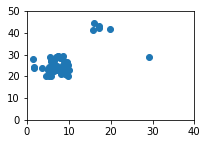

In [179]:
plt.figure(figsize=(3,2))
x=[]
y=[]
shots = recover_onehot(play_series)
for shot in shots:
    x.append(shot[0])
    y.append(shot[1])
plt.scatter(x,y)
plt.xlim(0,40)
plt.ylim(0,50)

33
33
33
45
41
41
41
40
33
33
33
33
33
33
67
67
67
67
67
41
41
41
41
41
41
41
41
41
41
41
41
41
33
33
33
33
33
33
33
33
33
33
33
33
33
33
32
32
32
32


(0, 50)

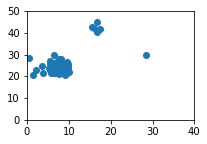

In [183]:
play_series_2 = play_generation.predict([x_initializer, a_initializer,c_initializer])
for item in play_series:
    print(np.argmax(item))
plt.figure(figsize=(3,2))
x=[]
y=[]
shots = recover_onehot(play_series)
for shot in shots:
    x.append(shot[0])
    y.append(shot[1])
plt.scatter(x,y)
plt.xlim(0,40)
plt.ylim(0,50)

(0, 50)

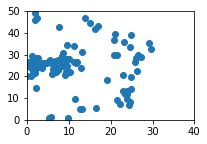

In [210]:
play_series_2 = play_generation_2.predict([discrete_shotlogs[0,50,:].reshape(1,1,8*10), a_initializer,c_initializer])

plt.figure(figsize=(3,2))
x=[]
y=[]
shots = recover_onehot(play_series_2)
for shot in shots:
    x.append(shot[0])
    y.append(shot[1])
plt.scatter(x,y)
plt.xlim(0,40)
plt.ylim(0,50)

(0, 50)

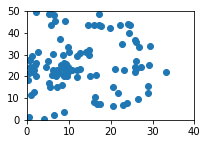

In [212]:
play_series_2 = play_generation_2.predict([discrete_shotlogs[0,0,:].reshape(1,1,8*10), a_initializer,c_initializer])

plt.figure(figsize=(3,2))
x=[]
y=[]
shots = recover_onehot(play_series_2)
for shot in shots:
    x.append(shot[0])
    y.append(shot[1])
plt.scatter(x,y)
plt.xlim(0,40)
plt.ylim(0,50)

(0, 50)

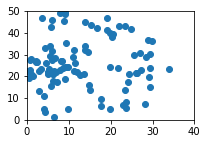

In [213]:
play_series_3 = play_generation_3.predict([discrete_shotlogs[0,0,:].reshape(1,1,8*10), a_initializer,c_initializer])

plt.figure(figsize=(3,2))
x=[]
y=[]
shots = recover_onehot(play_series_3)
for shot in shots:
    x.append(shot[0])
    y.append(shot[1])
plt.scatter(x,y)
plt.xlim(0,40)
plt.ylim(0,50)

In [218]:
def save_to_file(filename):
    with open(filename,'w') as f:
        for i in range(len(discrete_shotlogs)):
            shot_series = \
            play_generation_2.predict([discrete_shotlogs[i,0,:].reshape(1,1,8*10), a_initializer,c_initializer])
            print(' '.join([str(np.argmax(x)) for x in shot_series]), file=f)
    f.close()


In [239]:
def save_to_file_random(filename):
    with open(filename,'w') as f:
        for i in range(len(discrete_shotlogs)):
            random_idx = int(np.random.uniform(1, num_features,1)[0])
            initial_loc = np.zeros((1,1,num_features))
            initial_loc[0,0,random_idx] = 1
            shot_series = \
            play_generation_2.predict([initial_loc, a_initializer,c_initializer])
            print(' '.join([str(np.argmax(x)) for x in shot_series]), file=f)
    f.close()

In [219]:
save_to_file('synthetic_play.dat')

In [240]:
save_to_file_random('random_synthetic_play.dat')

In [224]:
def plot_from_file(filename):
    plt.figure(figsize=(15,10))
    with open(filename, 'r') as f:
        idx = 0
        for line in f:
            vals = [int(x) for x in line.split(' ')]
            shots = []
            for v in vals:
                x = v % 8
                y = v // 8
                x = np.random.uniform(x*5, (x+1)*5)
                y = np.random.uniform(y*5, (y+1)*5)
                shots.append([x,y])
            plt.subplot(2,4,idx+1)
            x = []
            y = []
            for shot in shots:
                x.append(shot[0])
                y.append(shot[1])
            plt.scatter(x,y)
            plt.xlim(0,40)
            plt.ylim(0,50)
            idx += 1

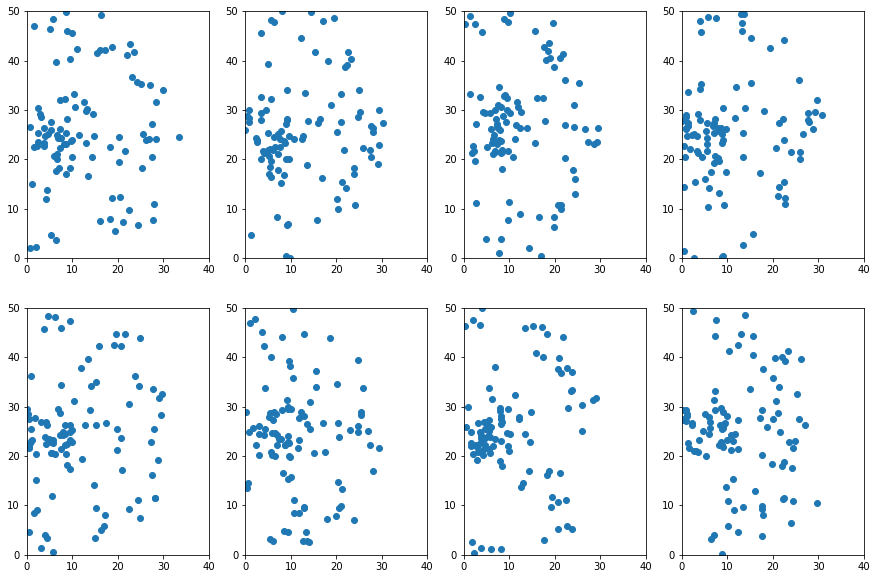

In [225]:
plot_from_file('synthetic_play.dat')

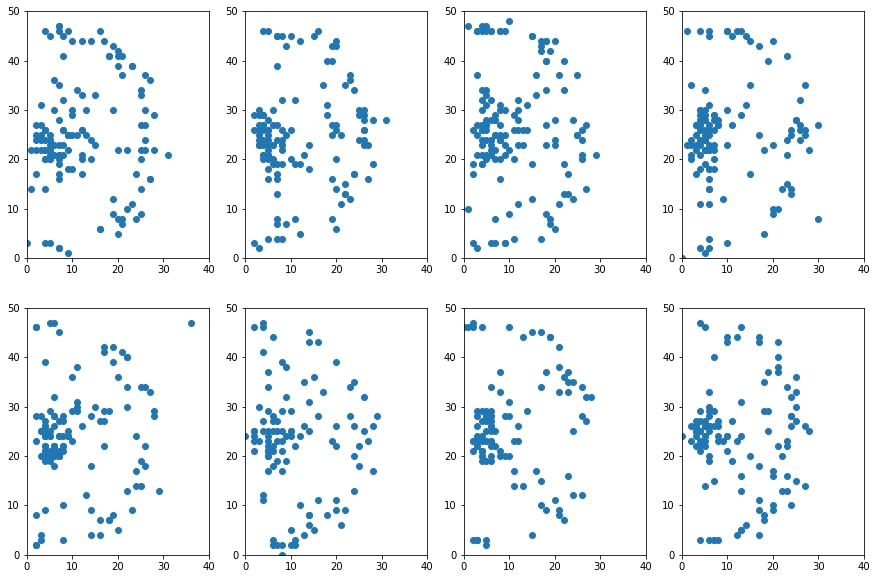

In [226]:
plt.figure(figsize=(15,10))
for idx,game in enumerate(new_duke_shotlogs.keys()):
    plt.subplot(2,4,idx+1)
    x= []
    y= []
    for item in new_duke_shotlogs[game]:
        x.append(item[1])
        y.append(item[2])
    plt.scatter(x,y)
    plt.xlim(0,40)
    plt.ylim(0,50)
#     for i in range(0,50,5):
#         plt.hlines(i,0,40)
#     for i in range(0,40,5):
#         plt.vlines(i, 0, 50)

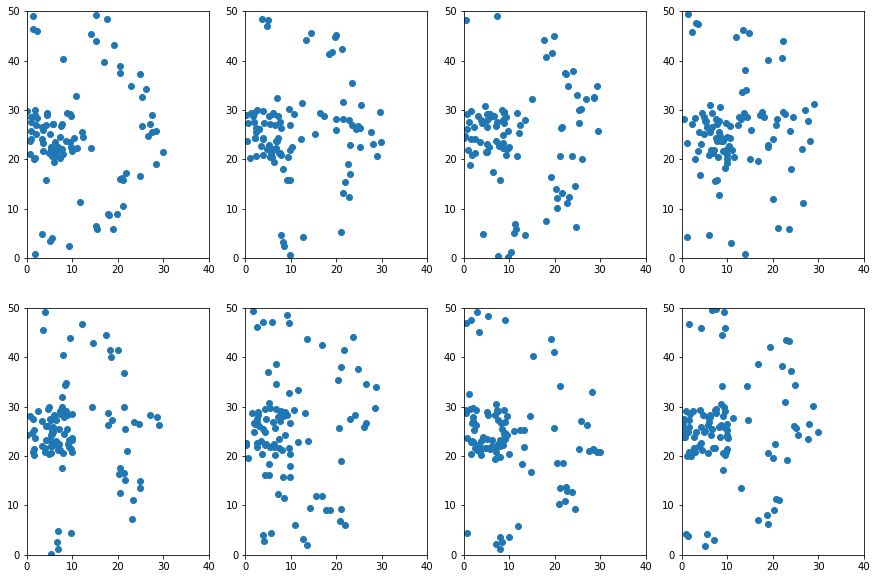

In [241]:
plot_from_file('random_synthetic_play.dat')

In [1]:
from mpl_toolkits import mplot3d
def plot_from_file_3d(filename):
    plt.figure(figsize=(15,10))
    with open(filename, 'r') as f:
        idx = 0
        time_dim = 0
        for line in f:
            vals = [int(x) for x in line.split(' ')]
            time_dim = len(vals)
            shots = []
            for v in vals:
                x = v % 8
                y = v // 8
                x = np.random.uniform(x*5, (x+1)*5)
                y = np.random.uniform(y*5, (y+1)*5)
                shots.append([x,y])
            plt.subplot(2,4,idx+1)
            ax = plt.axes(projection='3d')
            x = []
            y = []
            for shot in shots:
                x.append(shot[0])
                y.append(shot[1])
                z = range(time_dim)
            #plt.scatter(x,y)
            ax.plot3D(x, y, z)
            plt.xlim(0,40)
            plt.ylim(0,50)
            idx += 1

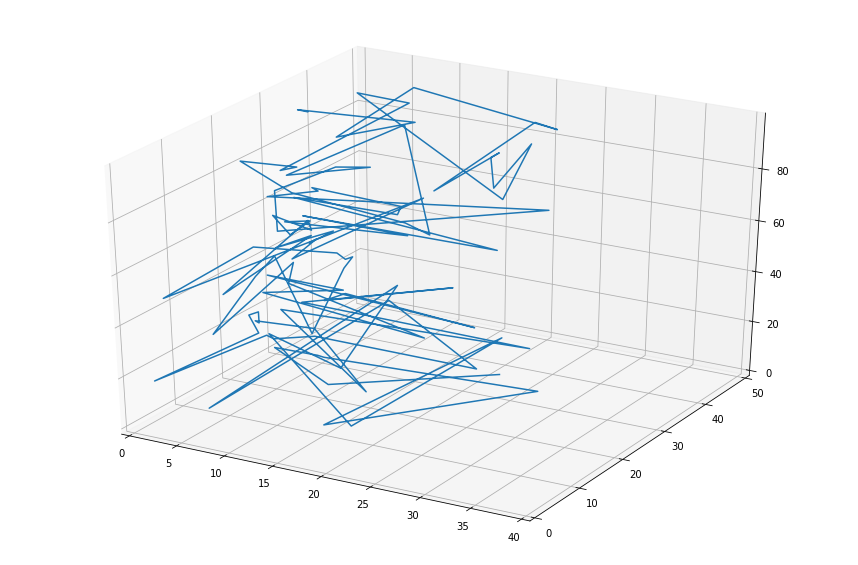

In [3]:
plot_from_file_3d('random_synthetic_play.dat')